In [20]:
###load data####
import pandas as pd
data = pd.read_csv("spam.csv", encoding = "latin-1")
data = data[['v1', 'v2']]
data = data.rename(columns = {'v1': 'label', 'v2': 'text'})
data = data.replace(to_replace =["ham", "spam"], value =[0, 1])

In [21]:
data

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [22]:
#####split train data and test data########
import numpy as np
def train_test_split(data, rate):
    totalTextNumber = data.shape[0]
    trainIndex = []
    testIndex = []

    for i in range(totalTextNumber):
        if(np.random.uniform(0, 1) < rate):
            trainIndex += [i]
        else:
            testIndex += [i]
    trainText = data.loc[trainIndex]
    testText = data.loc[testIndex]
    return trainText, testText

In [23]:
trainText, testText = train_test_split(data, 0.75)
trainText.reset_index(inplace = True)
trainText.drop(['index'], axis = 1, inplace = True)
trainText

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
4169,0,Ok lor... Sony ericsson salesman... I ask shuh...
4170,0,Why don't you wait 'til at least wednesday to ...
4171,1,REMINDER FROM O2: To get 2.50 pounds free call...
4172,1,This is the 2nd time we have tried 2 contact u...


In [24]:
####preprocess data#######
import nltk
nltk.download('stopwords')

from nltk import stem
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
def stemming(words):
    stemmer = stem.SnowballStemmer('english')
    words = [stemmer.stem(word) for word in words]
    return words
def remove_stop_words(words):
    stop_words = stopwords.words('english')
    words = [word for word in words if word not in stop_words]
    return words
def lower_case(text):
    text = text.lower()
    return text
def pre_process(text):
    text = lower_case(text)
    words = nltk.word_tokenize(text)
    words = [word for word in words if len(word) > 1]
    words = stemming(words)
    words = remove_stop_words(words)
    return words

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lijialiu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
words = pre_process("I am a student, hi, haha.....")
words

['student', 'hi', 'haha', '...', '..']

In [26]:
######calssifier########
class spamCalssifier(object):
    def __init__(self, trainText):
        self.text = trainText['text']
        self.label = trainText['label']

    def train(self):
        self.tf_and_idf()  # compute the values needed for tf_idf function
        self.tf_idf()
        
    def tf_and_idf(self):
        self.ham_text = self.label.value_counts()[0]
        self.spam_text = self.label.value_counts()[1]
        self.total_texts = self.label.shape[0]
        self.total_ham = 0    #total words in ham texts
        self.total_spam = 0   #total words in spam texts
        self.tf_ham = {}
        self.tf_spam = {}
        self.idf_countText = {}   # the number of messages containing w
        
        for i in range(self.total_texts):
            
            #print(self.text[i])
            
            processed_words = pre_process(self.text[i])
            
            #print(processed_words)
            #exit()
            
            contain_words = set()
            for word in processed_words:
                contain_words.add(word)
                if self.label[i] == 1:
                    self.tf_spam[word] = self.tf_spam.get(word, 0) + 1
                    self.total_spam += 1
                else:
                    self.tf_ham[word] = self.tf_ham.get(word, 0) + 1
                    self.total_ham += 1
        
            for word in contain_words:
                    self.idf_countText[word] = self.idf_countText.get(word, 0) + 1
    
    def tf_idf(self):
        self.prob_spam = {}   # p(w|spam) = tf_spam[w] * idf(w) / (summaton of p(w|spam) for all w)
        self.prob_ham = {}    # p(w|ham) 
        self.idf = {}        # idf(w) = log(the number of texts / the number of texts containing w)
        self.sum_tf_idf_spam = 0
        self.sum_tf_idf_ham = 0
        for word in self.tf_spam:
            self.idf[word] = np.log(self.total_texts / self.idf_countText[word])
            self.prob_spam[word] = self.tf_spam[word]* self.idf[word]
            self.sum_tf_idf_spam += self.prob_spam[word]
            
        for word in self.tf_spam:
            self.prob_spam[word] = (self.prob_spam[word] + 1) / (self.sum_tf_idf_spam + len(self.prob_spam))
        
        for word in self.tf_ham:
            self.idf[word] = np.log(self.total_texts / self.idf_countText[word])
            self.prob_ham[word] = self.tf_ham[word]* self.idf[word]
            self.sum_tf_idf_ham += self.prob_ham[word]
            
        for word in self.tf_ham:
            self.prob_ham[word] = (self.prob_ham[word] + 1) / (self.sum_tf_idf_ham + len(self.prob_ham))
        self.prob_spam_text = self.spam_text / self.total_texts
        self.prob_ham_text = self.ham_text / self.total_texts
        
        
    def classify(self, text):
        prob_spamText = 0
        prob_hamText = 0
        
        for word in text:
            if word in self.prob_spam:
                prob_spamText += np.log(self.prob_spam[word])
            else:
                prob_spamText -= np.log(self.sum_tf_idf_spam + len(self.prob_spam))
                
            if word in self.prob_ham:
                prob_hamText += np.log(self.prob_ham[word])
            else:
                prob_hamText -= np.log(self.sum_tf_idf_ham + len(self.prob_ham))
                
        prob_spamText -= np.log(self.prob_spam_text)
        prob_hamText -= np.log(self.prob_ham_text)
        
        return prob_spamText >= prob_hamText
    
    def predict_test(self, testText):
        result = {}
        for i in range(testText.shape[0]):
            words = pre_process(testText['text'][i])
            result[i] = int(self.classify(words))
        return result

In [27]:
myClassifier = spamCalssifier(trainText)
myClassifier.train()

In [28]:
testText.reset_index(inplace = True)
testText.drop(['index'], axis = 1, inplace = True)
testText

,label,text
0,1,Had your mobile 11 months or more? U R entitle...
1,0,I'm gonna be home soon and i don't want to tal...
2,0,I've been searching for the right words to tha...
3,0,Eh u remember how 2 spell his name... Yes i di...
4,0,Fine if thatåÕs the way u feel. ThatåÕs the wa...
...,...,...
1393,0,Ard 6 like dat lor.
1394,0,Huh y lei...
1395,0,Will Ì_ b going to esplanade fr home?
1396,0,"Pity, * was in mood for that. So...any other s..."


In [29]:
result = myClassifier.predict_test(testText) 

In [33]:
def performace(result, testText):

    correct = 0
    for i in range(len(result)):
        if testText['label'][i] == result[i]:
            correct += 1

    return correct/len(result)

In [34]:
print(performace(result, testText))

0.9184549356223176


In [51]:
#####test data and plot the performance
performance_values = []

for i in np.arange(0.6, 0.85, 0.03):
    trainText, testText = train_test_split(data, i)
    trainText.reset_index(inplace = True)
    trainText.drop(['index'], axis = 1, inplace = True)
    testText.reset_index(inplace = True)
    testText.drop(['index'], axis = 1, inplace = True)
    myClassifier = spamCalssifier(trainText)
    myClassifier.train()
    result = myClassifier.predict_test(testText) 
    performance_values += [performace(result, testText)]
    


(0.5, 1)

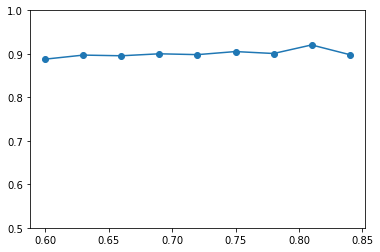

In [56]:
import matplotlib.pyplot as plt 
plt.plot(np.arange(0.6, 0.85, 0.03), performance_values, '-o')
plt.ylim((0.5, 1))